<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Using Natural Language Processing (NLP) Modelling to Predict Desktop CPU Brand Popularity

# Part 6 - Production Model Analysis and Deployment
### Contents:

- [Production Model Feature Analysis](#Production-Model-Feature-Analysis)
- [Production Model Error Analysis](#Production-Model-Error-Analysis)
- [Deployment and Recommendations](#Deployment-and-Recommendations)
- [Conclusion](#Conclusion)

In [3]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import spacy
import re

In [4]:
#read the train_df Data
df = pd.read_csv('./train_csv.csv')

In [5]:
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
sw_spacy = list(sw_spacy)

new_spacy = []
for word in sw_spacy:
    if "'" not in word:
        new_spacy.append(word)

new_spacy.append('amd')
new_spacy.append('intel')
new_spacy.append('ll')
new_spacy.append('ve')
new_spacy.append('nt')

#load the stopwords removed from error analysis
stopwords_missclass = pd.read_csv('./stopwords_csv.csv')

new_spacy.extend(stopwords_missclass['Word'].values.tolist())

## Production Model Feature Analysis

In [6]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)


performance_df = pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.93535,0.968979,0.937094,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."


In [17]:
#Extracting the Logreg Coef for the features in the model
coef_df = []
for x,y in zip(gs.best_estimator_[0].get_feature_names_out(), gs.best_estimator_[1].coef_.tolist()[0]):
    coef_df.append([x, y])

logreg_coef = pd.DataFrame(coef_df, columns = ['Word', 'LogReg Coeff'])

display(logreg_coef.sort_values('LogReg Coeff', ascending=False).head(25))
display(logreg_coef.sort_values('LogReg Coeff', ascending=False).tail(25))

,Word,LogReg Coeff
22469,ryzen,10.026568
5210,5800x,6.362277
5285,5900x,6.138136
29284,x570,5.835728
20675,radeon,5.590132
22406,rx,5.337486
5059,5600x,5.268505
29497,xt,5.037801
5317,5950x,4.954352
5929,6900xt,4.744362


,Word,LogReg Coeff
29743,z590,-2.811660
211,10400f,-2.821500
29533,xtu,-2.891855
618,11900k,-3.027393
6958,8700k,-3.035111
29709,z390,-3.095983
26960,uhd,-3.202092
29372,xe,-3.338406
29382,xeon,-3.448638
17834,optane,-3.466065


Looking at the LogReg coefficients for the production model we see that the trend identified in EDA is replicated here. The highly important features with high absolute LogReg coefficient are those words that are brand specific model names/SKUs.

## Production Model Error Analysis

C:\Users\rashi\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix for AMD (Positive Class) vs. Intel (Negative Class)')

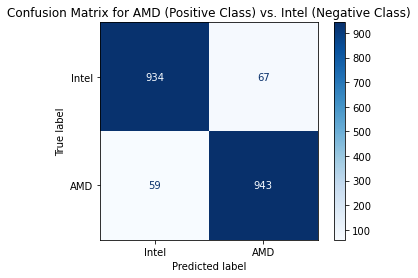

In [8]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Intel', 'AMD']);

plt.title('Confusion Matrix for AMD (Positive Class) vs. Intel (Negative Class)')

In [9]:
# create a dataframe to contain the posts, actual reddit and predicted reddit
y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['isAMD_true'] = y_test.values
y_test_pred_df['isAMD_pred'] = gs.predict(X_test)
y_test_pred_df.set_index('index', drop= True, inplace=True)
y_test_pred_df = pd.concat([y_test_pred_df, pd.DataFrame(X_test)], axis = 1)

#extracting the False negative and False Positive posts (misclassified posts)
fn_df = y_test_pred_df[(y_test_pred_df['isAMD_true'] == 1) & (y_test_pred_df['isAMD_pred'] == 0)]
fn_df.reset_index(drop= True, inplace= True)
fp_df = y_test_pred_df[(y_test_pred_df['isAMD_true'] == 0) & (y_test_pred_df['isAMD_pred'] == 1)]
fp_df.reset_index(drop= True, inplace= True)


When looking through the texts that makes up the False Positive/Negative, the following trends were observed:

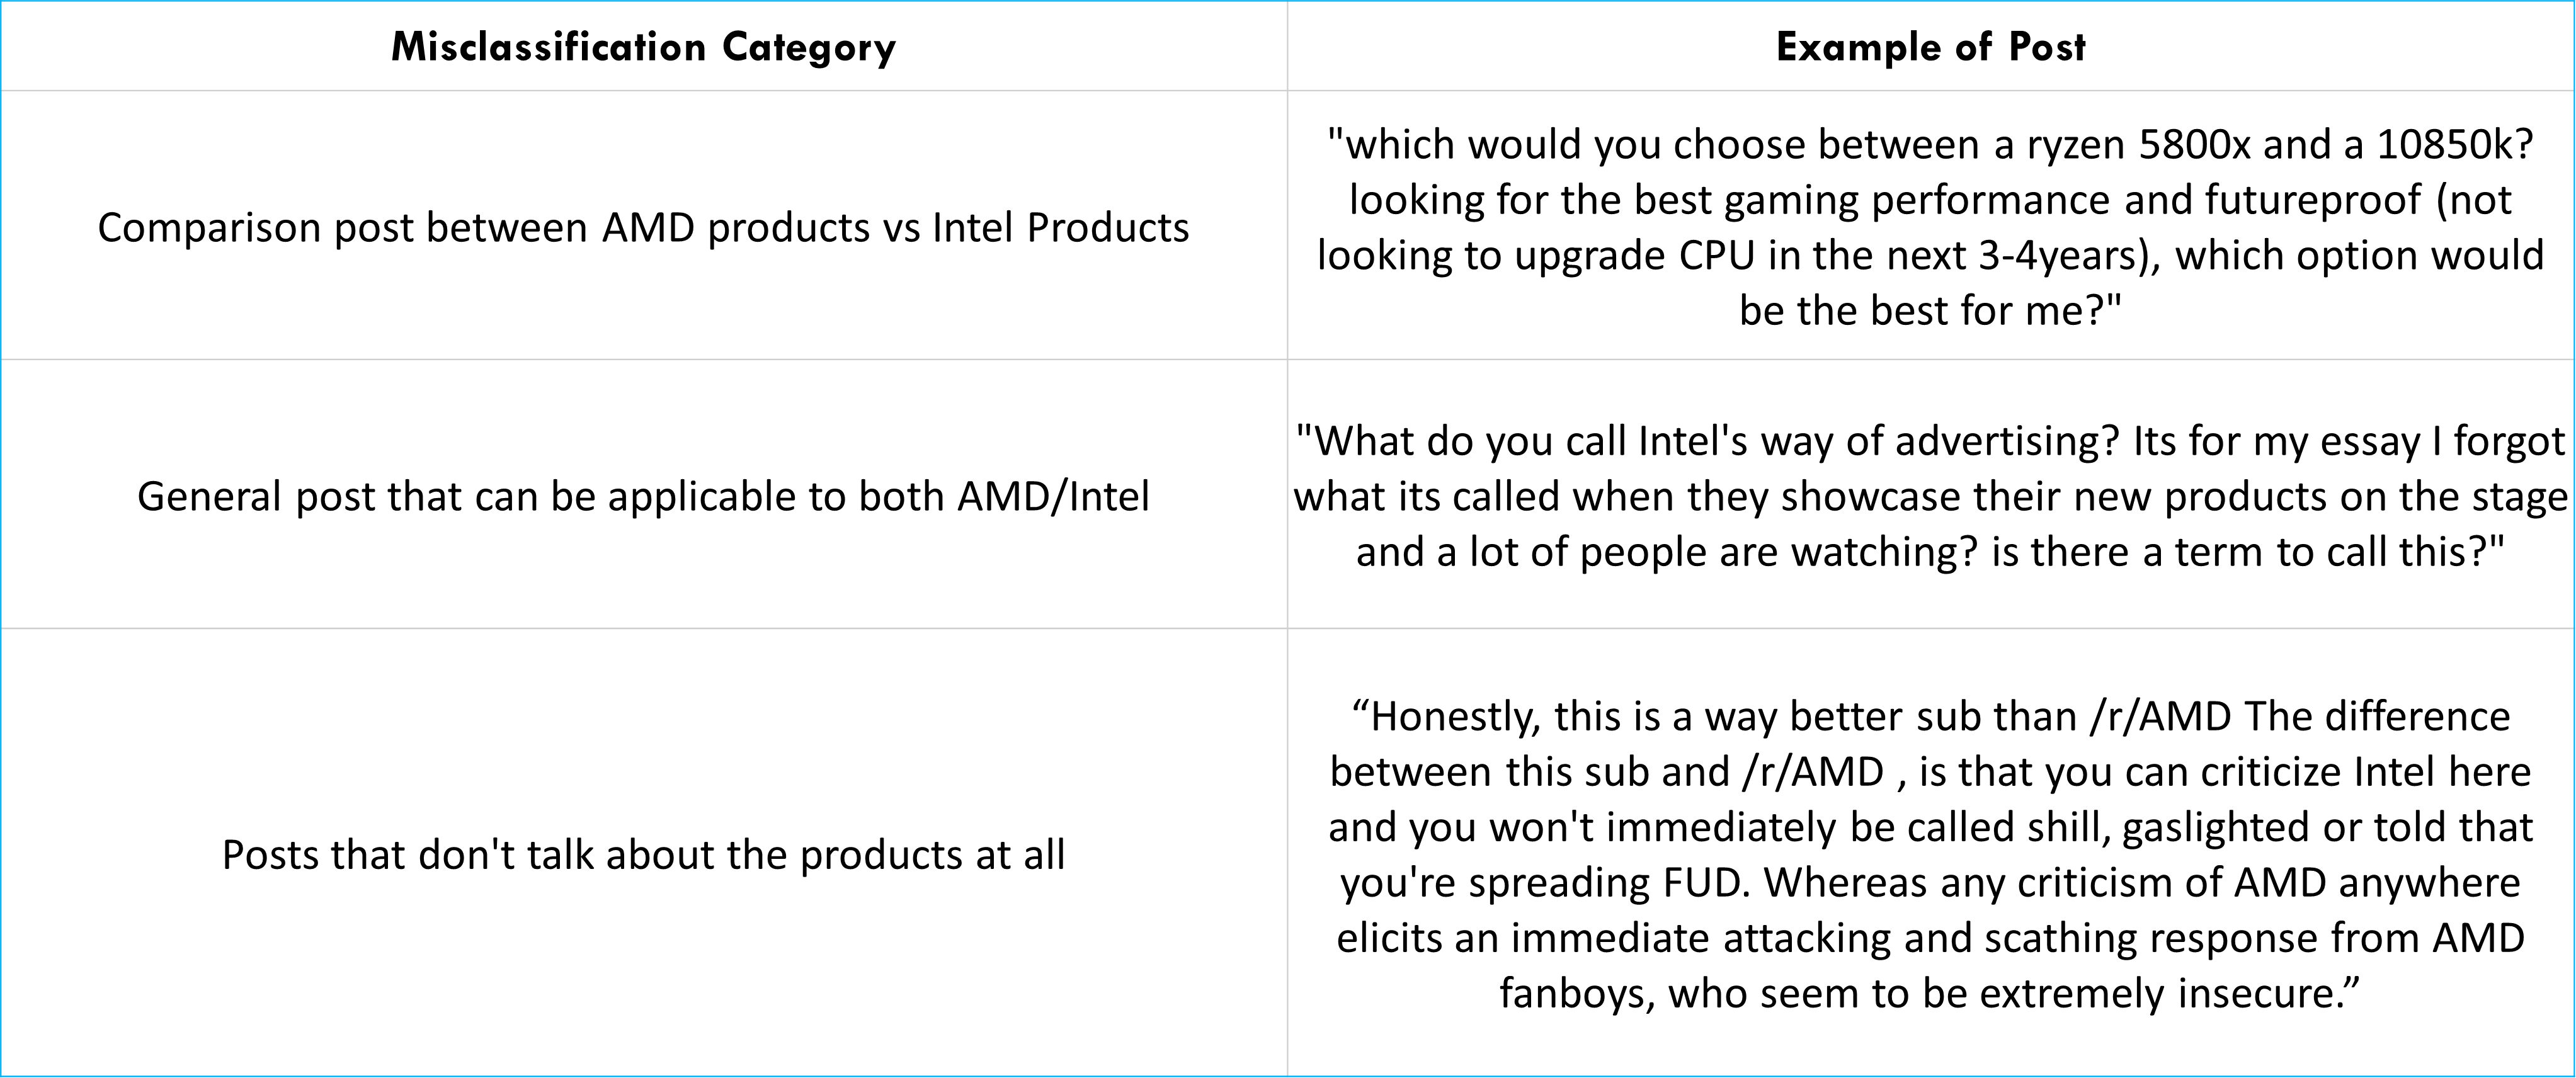

Posts from the first misclassification category cannot be helped or improved on because the descriptors for both ```r/AMD``` and ```r/Intel``` were used and it depends highly the LogReg coef of the important features.

For the second and third category, more Stopwords Engineering to add in the words used in these posts. These could be done to improve the model however it will take up a lot of manual effort without real/significant returns.

## Deployment and Recommendations

Firstly, we will retrain our Production model over the whole train dataset.

In [19]:
X = df['text']
y = df['subreddit_isAMD']

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__stop_words' : [new_spacy],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

# Fit GridSearch to training data.
gs.fit(X, y)


performance_df = pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X, y)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,params
0,TfidfVectorizer(),LogisticRegression(max_iter=5000),0.93043,0.968237,"{'tvec__max_features': 30000, 'tvec__ngram_ran..."


Now, we will read in the ```r/BuildaPC``` dataset and clean it before running it through our model to generate predictions on the class.

In [20]:
buildapc = pd.read_csv('./buildapc_csv.csv')

In [25]:
#Cleaning up our data
#merging title and selftext
buildapc['text'] = buildapc['title'] + ' ' + buildapc['selftext']
#removing links
buildapc['text'] = buildapc['text'].map(lambda x: re.sub(r"http.:+[^\s]+[\w]", '', x))
#removing &amp;
buildapc['text'] = buildapc['text'].map(lambda x: x.replace('&amp;',''))
#removing #x200B;
buildapc['text'] = buildapc['text'].map(lambda x: x.replace('#x200B;',''))
#removing &lt;
buildapc['text'] = buildapc['text'].map(lambda x: x.replace('&lt;',''))
#removing &gt;
buildapc['text'] = buildapc['text'].map(lambda x: x.replace('&gt;',''))
#removing \n
buildapc['text'] = buildapc['text'].map(lambda x: x.replace('\n',''))

In [26]:
#generating predictions
amd_intel = pd.DataFrame(gs.predict(buildapc['text']))   
amd_intel['Brand'] = amd_intel[0].map(lambda x: 'AMD' if x == 1 else 'Intel')

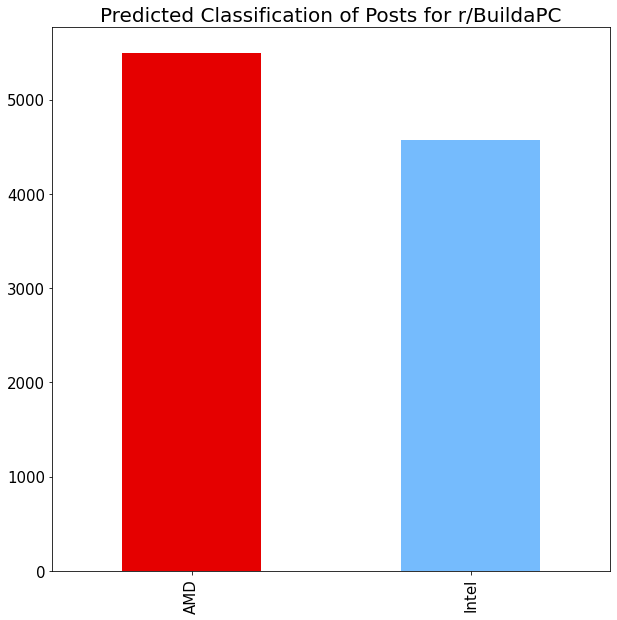

In [28]:
#plotting bar graph of AMD vs. Intel in r/BuildaPC
amd_intel['Brand'].value_counts().plot(kind='bar', color=['xkcd:red', 'xkcd:sky blue'], figsize = [10,10], fontsize = 15);

plt.title('Predicted Classification of Posts for r/BuildaPC', size=20);

From our production model, the majority of the 10,000 posts from ```r/BuildaPC``` are talking about AMD and hence I will be choosing to carry AMD CPUs for my custom PC building startup!

## Conclusion

### Production Model Summary

Although the current model with ~93.7% test score accuracy may be sufficient to answer the current problem statement, more can be done to increase the accuracy and hence the predictive strength of the model. A few ways to go about it within the current scope of the tools used in this project is:

1) Deep-dive into Stopwords engineering to remove more words with low feature importance.<br>
2) Instead of choosing one model with the best base score and proceeding to improve it through Hyperparameter tuning, it may be better to tune for all models since some classifiers may have a higher accuracy score ceiling if tuned properly.<br>

Lastly, since accuracy is the the only measure for this problem statment, it would be good to explore black-box models (like Support Vector Machines (SVMs) or deep learning models like BERT that has better algorithm to improve the accuracy of the model and provide better predictions when deployed.

### Project Insights

Initially we see that Intel has a more dominant market share, but when we zoom in specifically into our Target Market, AMD is the preferred brand of choice for their CPUs.

As an avid Custom PC builder myself, this lies in line with my perception of the current state of the matters in the enthusiast/gamer PC building space with how much the subreddit users and also tech YouTube channels often opting for AMD CPUs in their PC builds.

Of course with the competition for dominance so tight, the general perception of a certain CPU brand's supremacy will change over time. It is important to keep doing this analysis periodically to update my startups' business startegy.


### Possible Future Works

- Run sentiment analysis to see whether posts are positive or negative against AMD and Intel.
    - Quantity is not the only measure for popularity.
- Do multiclass classification for the GPU market (Nvidia RTX, AMD Radeon, Intel Arc) to see which GPU brand I should carry.
    - Since GPUs are the next big component in a Desktop PC and costs more than the CPU.
- Automate the process so that frequent market analysis can be done in order to update the business strategy.

